## Load Data

In [21]:
import os
import numpy as np
import pandas as pd
import random
import json
from rdkit import Chem

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [16,9]

from tqdm import tqdm

import torch

In [22]:
#create two dims lists: 1st dim SMILES, 2nd dim chars in SMILES
max_sequence_length = 120
data_dir = './data/'
train_file = 'smiles_train.smi'
dataset_raw_file = os.path.join(data_dir, train_file)
smiles_lst = []
with open(dataset_raw_file, 'r') as file:
    for seq in file.readlines():
        words = list(seq)[:-1]
        smiles_lst.append(''.join(words))
file.close()
smiles_train = smiles_lst

In [23]:
#create SMILES target list (all 250K SMILES)
data_dir = './data/'
target_file = '250k_rndm_zinc_drugs_clean.smi'
dataset_raw_file = os.path.join(data_dir, target_file)
smiles_lst = []
with open(dataset_raw_file, 'r') as file:
    for seq in file.readlines():
        words = list(seq)[:-1]
        smiles_lst.append(''.join(words))
file.close()
smiles_target = smiles_lst

In [24]:
#create two dims lists: 1st dim SMILES, 2nd dim chars in SMILES
max_sequence_length = 120
data_dir = './data/'
train_file = 'smiles_train.smi'
dataset_raw_file = os.path.join(data_dir, train_file)
smiles_lst = []
with open(dataset_raw_file, 'r') as file:
    for seq in file.readlines():
        seq = seq + '?' * (max_sequence_length - len(seq))
        words = list(seq)
        smiles_lst.append(words)
file.close()

In [25]:
#print the first SMILES, using '?' as padding char
print(''.join(smiles_lst[0]))

CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1
????????????????????????????????????????????????????????????????????????????????


In [26]:
#print chars in the first SMILES
print(smiles_lst[0])

['C', 'C', '(', 'C', ')', '(', 'C', ')', 'c', '1', 'c', 'c', 'c', '2', 'o', 'c', 'c', '(', 'C', 'C', '(', '=', 'O', ')', 'N', 'c', '3', 'c', 'c', 'c', 'c', 'c', '3', 'F', ')', 'c', '2', 'c', '1', '\n', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?']


In [27]:
#create a 2D array
smiles_array = np.array(smiles_lst)

## Naive Sampler (1-gram, random sampling)

Build a naive sampler that samples chars at each position using their marginal distributions. Stop when encounter '\n'

In [28]:
def naive_sampler(smiles_array):
    
    n_row, n_col = smiles_array.shape
    char = '?'
    
    i_col = 0
    sample_smile = []
    while (i_col < n_col and char != '\n'):
        
        sample_array = smiles_array[:,i_col] #select the ith column of SMILES array
        pad_idx = sample_array == '?' #remove paddings
        sample_array = sample_array[~pad_idx] #remove paddings
        char = np.random.choice(sample_array,size=1)[0] #randomly sample a char from the marginal dist of ith position 
        sample_smile.append(char)
        
        i_col +=1  
        
    return sample_smile

In [29]:
sample_smile = naive_sampler(smiles_array)
print("".join(sample_smile))
print(sample_smile)

COCCScc]CCcH)CC=C)(HNC(N1C=[=(cnnC2O4C2C=C2OC2@OF)

['C', 'O', 'C', 'C', 'S', 'c', 'c', ']', 'C', 'C', 'c', 'H', ')', 'C', 'C', '=', 'C', ')', '(', 'H', 'N', 'C', '(', 'N', '1', 'C', '=', '[', '=', '(', 'c', 'n', 'n', 'C', '2', 'O', '4', 'C', '2', 'C', '=', 'C', '2', 'O', 'C', '2', '@', 'O', 'F', ')', '\n']


generate 1000 random samples

In [30]:
naive_sample_smiles = []
n_sample = 1000
for i in range(n_sample):
    sample_smile = naive_sampler(smiles_array)
    sample_smile_string = ''.join(sample_smile[:-1])
    naive_sample_smiles.append(sample_smile_string)

## VAE Sampler ( z ~ prior, greedy sampling)

In [31]:
def smile_generator(directory, vocab_file, model_file, nsample, max_sequence_length):

    w2i, i2w = idx2word(directory, vocab_file)

    eos_idx = w2i['<eos>']

    model = torch.load(model_file)
    model.eval()  # model.eval() will notify all your layers that you are in eval mode, that way, batchnorm or dropout layers will work in eval model instead of training mode.

    samples_idx, z = model.inference(n=nsample)

    smiles_lst = []
    for i in range(nsample):
        smiles = []
        for j in range(max_sequence_length):
            if samples_idx[i,j] == eos_idx:
                break
            smiles.append(i2w[samples_idx[i,j].item()])
        smiles = "".join(smiles)
        smiles_lst.append(smiles)
    return smiles_lst, z
    

            
def idx2word(directory, vocab_file):
    w2i = dict()
    i2w = dict()

    # add special tokens to vocab
    special_tokens = ['<pad>', '<unk>', '<sos>', '<eos>']
    for st in special_tokens:
        i2w[len(w2i)] = st
        w2i[st] = len(w2i)

    # load unique chars
    char_list = json.load(open(os.path.join(directory, vocab_file)))
    for i, c in enumerate(char_list):
        i2w[len(w2i)] = c
        w2i[c] = len(w2i)

    return w2i, i2w


In [57]:
data_dir = "/Users/keyu/PycharmProjects/DrugEmbedding/data/"
vocab_file = "zinc_char_list.json"
nsample = 1000
max_sequence_length = 120
vae_smiles_sample, z = smile_generator(data_dir, vocab_file, 'logistic_KL_annealing_mdl', nsample, max_sequence_length)


### SMILES Frequency

In [58]:
unique_vae_smiles = list(set(vae_smiles_sample))

In [59]:
len(unique_vae_smiles)

367

In [60]:
smi_freq_lst = []
for smi in unique_vae_smiles:
    #count of duplicate smiles
    smi_cnt = vae_smiles_sample.count(smi)
    
    #valid or invalide
    if type(Chem.MolFromSmiles(smi)) is rdkit.Chem.rdchem.Mol:
        smi_valid = 1
    else:
        smi_valid = 0
    
    #exist in training data or not?
    if smi in smiles_train:
        in_train = 1
    else:
        in_train = 0
    
    #exist in the whole dataset or not?
    if smi in smiles_target:
        in_target = 1
    else:
        in_target = 0
        
    smi_freq_lst.append([smi, smi_cnt, smi_valid, in_train, in_target])
smi_freq_df = pd.DataFrame(smi_freq_lst,columns = ['VAE_SMILES','COUNT','VALID','IN_TRAIN','IN_TARGET'])

In [61]:
smi_freq_df.sort_values(by=['COUNT'], ascending=False)

,VAE_SMILES,COUNT,VALID,IN_TRAIN,IN_TARGET
362,C[C@H](CC(=O)c1ccc(Cl)cc1)C(=O)N1CCC[C@H](C(F)...,42,1,0,0
337,Cc1ccc(C(=O)N2CCC[C@@H](c3nnc(Cn4cccn4)n3C)C2)cc1,31,1,0,0
183,Cc1ccc(C(=O)N[C@H](C)c2ccc(Cl)s2)cc1,22,1,0,0
152,Cc1ccc(C(=O)N2CCC[C@H](C(=O)Nc3ccc(F)cc3)C2)cc1,22,1,0,0
29,COc1ccc(C)cc1NC(=O)C(=O)Nc1ccc(C(=O)NC(C)C)cc1,21,1,0,0
100,COc1ccc(C(=O)N[C@H](C)c2ccc(C)cc2)cc1OC,17,1,0,0
164,C[C@H](CC(=O)[O-])[C@H](C)NC(=O)C(=O)Nc1ccc(C(...,17,1,0,0
145,CC(C)(C)OC(=O)N1CCC[C@@H](C(=O)Nc2cccc(Cl)c2)C1,17,1,0,0
240,CC[C@H](C)[C@@H](C)NC(=O)C(=O)Nc1ccc(C(=O)NC(C...,17,1,0,0
295,COc1ccc([C@@H]2C(=O)Nc3ccccc3C2=O)cc1C(=O)N(C)C,16,1,0,0


In [62]:
#check validity
print('%d VAE generated SMILES are valid molecules'%smi_freq_df['VALID'].sum())
print('%d VAE generated SMILES are in training data'%smi_freq_df['IN_TRAIN'].sum())
print('%d VAE generated SMILES are in the 250K drug-like SMILES dataset'%smi_freq_df['IN_TARGET'].sum())

311 VAE generated SMILES are valid molecules
0 VAE generated SMILES are in training data
1 VAE generated SMILES are in the 250K drug-like SMILES dataset


# Navie Sampler vs. VAE Sampler

### SMILES length distribution

In [63]:
length_target = list(len(smi) for smi in smiles_target)
length_target = np.asarray(length_target)
print('The average length of target SMILES is %f'%length_target.mean())

length_naive = list(len(smi) for smi in naive_sample_smiles)
length_naive = np.asarray(length_naive)
print('The average length of naive sampled SMIELS is %f'%length_naive.mean())

length_vae = list(len(smi) for smi in vae_smiles_sample)
length_vae = np.asarray(length_vae)
print('The average length of VAE sampled smiles is %f'%length_vae.mean())

The average length of target SMILES is 44.310764
The average length of naive sampled SMIELS is 44.427000
The average length of VAE sampled smiles is 45.521000


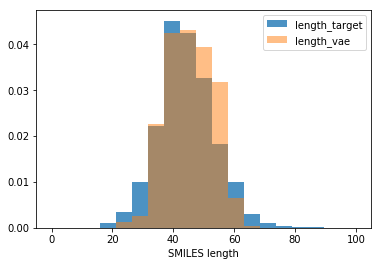

In [64]:
bins = np.linspace(0, 100, 20)

plt.hist(length_target, bins, alpha=0.8, label='length_target', density=True)
plt.hist(length_vae, bins, alpha=0.5, label='length_vae',density=True)
plt.legend(loc='upper right')
plt.xlabel('SMILES length')
plt.show()

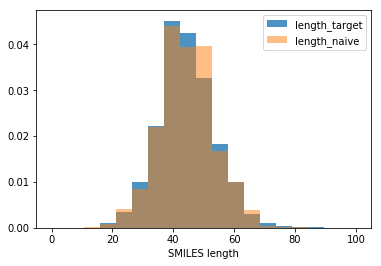

In [65]:
bins = np.linspace(0, 100, 20)

plt.hist(length_target, bins, alpha=0.8, label='length_target', density=True)
plt.hist(length_naive, bins, alpha=0.5, label='length_naive', density=True)
plt.legend(loc='upper right')
plt.xlabel('SMILES length')
plt.show()

<font color='red'><font size = '3'> COMMENTS </font>
* samples from both models match the true distribution of SMILES length
* VAE with greedy sampling are less likely to generate very long/short SMIELS (due to VAE or greedy sampling?)

### SMILES Validity

In [66]:
naive_v_cnt = 0
for smi in naive_sample_smiles:
    if type(rdkit.Chem.MolFromSmiles(smi)) is rdkit.Chem.rdchem.Mol:
        naive_v_cnt += 1

vae_v_cnt = 0
for smi in vae_smiles_sample:
    if type(rdkit.Chem.MolFromSmiles(smi)) is rdkit.Chem.rdchem.Mol:
        vae_v_cnt += 1

print('%d out of %d SMIELS generated by naive sampler is valid'%(naive_v_cnt,len(naive_sample_smiles)))
print('%d out of %d SMIELS generated by VAE sampler is valid'%(vae_v_cnt,len(vae_smiles_sample)))

0 out of 1000 SMIELS generated by naive sampler is valid
920 out of 1000 SMIELS generated by VAE sampler is valid


<font color='red'><font size = '3'> COMMENTS </font>
* VAE does much better in terms of syntactic validity

### Edit Distance to Nearest Neighbor

### Levenshtein distance

The Levenshtein distance is a string metric for measuring the difference between two sequences. Informally, it is the minimum number of single-character edits (insertions, deletions or substitutions) required to change one word into the other. (e.g. LevenDist (kitten, sitting) = 3: 1, kitten -> sitten, 2 sitten -> sittin, 3 sittin -> sitting)

In [67]:
def levenshtein(s1, s2):
    if len(s1) < len(s2):
        return levenshtein(s2, s1)

    # len(s1) >= len(s2)
    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1 # j+1 instead of j since previous_row and current_row are one character longer
            deletions = current_row[j] + 1       # than s2
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]

In [68]:
print(levenshtein('kitten','sitting')) 

3


In [69]:
target = smiles_target[:10000]

In [181]:
naive_smiles_dist = []
for i in tqdm(range(len(naive_sample_smiles))):
    smi_s = naive_sample_smiles[i]
    ld_min = 0
    for smi_t in target:
        ld = levenshtein(smi_s, smi_t)
        if ld > ld_min:
            ld_min = ld
    naive_smiles_dist.append(ld_min)   

100%|██████████| 1000/1000 [8:59:08<00:00, 10.45s/it]     


In [182]:
vae_smiles_dist = []
for i in tqdm(range(len(vae_smiles_sample))):
    smi_s = vae_smiles_sample[i]
    ld_min = 0
    for smi_t in target:
        ld = levenshtein(smi_s, smi_t)
        if ld > ld_min:
            ld_min = ld
    vae_smiles_dist.append(ld_min) 

100%|██████████| 1000/1000 [5:27:02<00:00,  7.33s/it]    


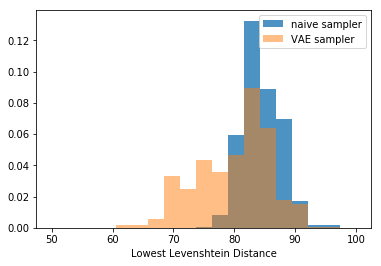

In [185]:
bins = np.linspace(50, 100, 20)

plt.hist(naive_smiles_dist, bins, alpha=0.8, label='naive sampler', density=True)
plt.hist(vae_smiles_dist, bins, alpha=0.5, label='VAE sampler', density=True)
plt.legend(loc='upper right')
plt.xlabel('Lowest Levenshtein Distance')
plt.show()

In [193]:
dist = [naive_smiles_dist, vae_smiles_dist]
pd.DataFrame(np.array(dist).T, columns = ['NAIVE LD', 'VAE LD']).describe()

,NAIVE LD,VAE LD
count,1000.000000,1000.000000
mean,84.385000,79.966000
std,3.147488,5.933131
min,74.000000,63.000000
25%,82.000000,76.000000
50%,84.000000,81.000000
75%,86.000000,85.000000
max,97.000000,95.000000


<font color='red'><font size = '3'> COMMENTS </font>
* VAE samples match true SMILES better than naive samples
* Levenshtein distance is computationally expensive and can only be used as an approxy to validty

## VAE Sampler ( z ~ q(z|x), greedy sampling)

* select a SMILE from training data
* find its mean in Z space
* sample 5 SMILES from decoder
* visualize SMILES in 2D molecular graph

In [70]:
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions #Only needed if mod

In [71]:
data_dir = "/Users/keyu/PycharmProjects/DrugEmbedding/data/"
vocab_file = "zinc_char_list.json"
model_file = 'logistic_KL_annealing_mdl'
w2i, i2w = idx2word(data_dir, vocab_file)
eos_idx = w2i['<eos>']
model = torch.load(model_file)

In [168]:
smile_1st = 'CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1'
input_sequence = [w2i['<sos>']]
for i in smile_1st:
    input_sequence.append(w2i[i])
input_sequence.append(w2i['<eos>'])
input_sequence = input_sequence + [0] * (max_sequence_length - len(input_sequence)-1)
input_sequence = np.asarray(input_sequence)
input_sequence = torch.from_numpy(input_sequence).unsqueeze(0)
sequence_length = torch.tensor([len(smile_1st)+1])

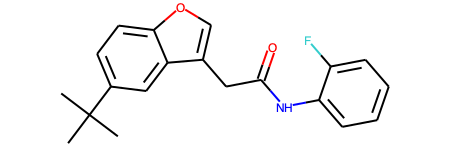

In [169]:
rdkit.Chem.MolFromSmiles(smile_1st)

### Generate SMILE with mean(z)

In [170]:
#sample from q(z|x), where x is ibuprofen
_, mean, logv, _= model.forward(input_sequence,sequence_length)

In [171]:
samples_idx,_ = model.inference(1,mean.unsqueeze(0))
smiles_lst = []
for i in range(1):
    smiles = []
    for j in range(max_sequence_length):
        if samples_idx[i,j] == eos_idx:
            break
        smiles.append(i2w[samples_idx[i,j].item()])
    smiles = "".join(smiles)
    smiles_lst.append(smiles)
print(smiles)

CC(C)(C)OC(=O)N1CCC[C@@H](C(=O)Nc2cccc(C(F)(F)F)c2)C1


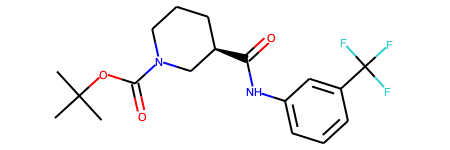

In [172]:
rdkit.Chem.MolFromSmiles(smiles)

<font color='red'><font size = '3'> COMMENTS </font>
* it matches a few local patterns (e.g. "CC(C)(C)" at beginning, "C(=O)Nc2cccc" in the middle, "c2)C1" at end) 

### Generate SMILES with z ~ q(z|x)

In [173]:
#sample from q(z|x), where x is ibuprofen
std = torch.exp(0.5 * logv)
z = torch.randn([5, mean.size(0)])
z = z * std + mean

In [174]:
samples_idx,_ = model.inference(z.size(0),z)

In [175]:
smiles_lst = []
for i in range(z.size(0)):
    smiles = []
    for j in range(max_sequence_length):
        if samples_idx[i,j] == eos_idx:
            break
        smiles.append(i2w[samples_idx[i,j].item()])
    smiles = "".join(smiles)
    smiles_lst.append(smiles)

In [176]:
for s in smiles_lst:
    print(s)

CC(C)(C)OC(=O)N1CCC[C@@H](C(=O)Nc2cccc(Cl)c2)C1
CC(C)(C)OC(=O)N1CCC[C@@H](C(=O)Nc2cccc(C(F)(F)F)c2)C1
CC(C)(C)OC(=O)c1ccc(C(=O)N[C@@H]2CCC[C@H](C)C2)cc1
CC(C)(C)OC(=O)N1CCC[C@@H](C(=O)Nc2cccc(Cl)c2)C1
Cc1ccc(C(=O)N2CCC[C@@H](c3nnc(Cn4cccn4)n3C)C2)cc1


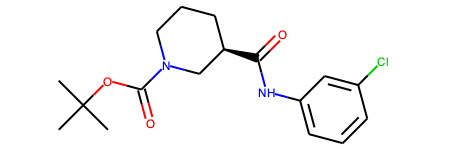

In [177]:
rdkit.Chem.MolFromSmiles('CC(C)(C)OC(=O)N1CCC[C@@H](C(=O)Nc2cccc(Cl)c2)C1')

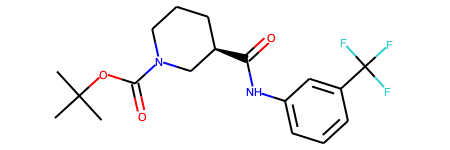

In [178]:
rdkit.Chem.MolFromSmiles('CC(C)(C)OC(=O)N1CCC[C@@H](C(=O)Nc2cccc(C(F)(F)F)c2)C1')

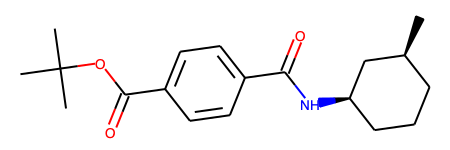

In [179]:
rdkit.Chem.MolFromSmiles('CC(C)(C)OC(=O)c1ccc(C(=O)N[C@@H]2CCC[C@H](C)C2)cc1')

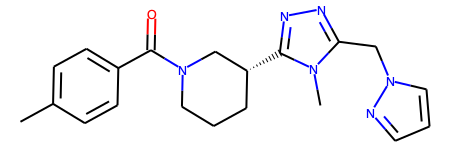

In [180]:
rdkit.Chem.MolFromSmiles('Cc1ccc(C(=O)N2CCC[C@@H](c3nnc(Cn4cccn4)n3C)C2)cc1')

## Try to generate SMILES with relatively rare elements

In [207]:
#smile_1st = 'O=C(Cc1ccc(NC(=O)c2ccc3ncsc3c2)cc1)NCC(F)(F)F'
smile_1st = 'CC[NH+](CC)[C@](C)(CC)[C@H](O)c1cscc1Br'
input_sequence = [w2i['<sos>']]
for i in smile_1st:
    input_sequence.append(w2i[i])
input_sequence.append(w2i['<eos>'])
input_sequence = input_sequence + [0] * (max_sequence_length - len(input_sequence)-1)
input_sequence = np.asarray(input_sequence)
input_sequence = torch.from_numpy(input_sequence).unsqueeze(0)
sequence_length = torch.tensor([len(smile_1st)+1])

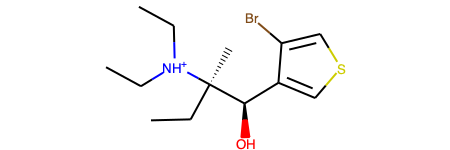

In [208]:
rdkit.Chem.MolFromSmiles(smile_1st)

In [209]:
#sample from q(z|x), where x is ibuprofen
_, mean, logv, _= model.forward(input_sequence,sequence_length)

In [210]:
samples_idx,_ = model.inference(1,mean.unsqueeze(0))
smiles_lst = []
for i in range(1):
    smiles = []
    for j in range(max_sequence_length):
        if samples_idx[i,j] == eos_idx:
            break
        smiles.append(i2w[samples_idx[i,j].item()])
    smiles = "".join(smiles)
    smiles_lst.append(smiles)
print(smiles)

CC[NH+](CC)[C@@H](C)C(=O)Nc1ccc(C(=O)NC(C)C)cc1


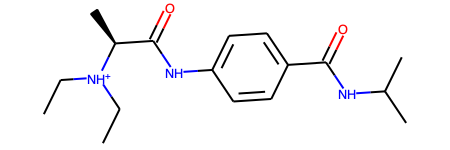

In [211]:
rdkit.Chem.MolFromSmiles(smiles)

<font color='red'><font size = '3'> COMMENTS </font>
* it failed to represent relatively rare atoms (e.g. Sulfur, Bromine)
* it was able to capture a couple of local patterns with more common chemical elments


In [303]:
#sample from q(z|x), where x is ibuprofen
std = torch.exp(0.5 * logv)
z = torch.randn([5, mean.size(0)])
z = z * std + mean

In [213]:
samples_idx,_ = model.inference(z.size(0),z)

In [214]:
smiles_lst = []
for i in range(z.size(0)):
    smiles = []
    for j in range(max_sequence_length):
        if samples_idx[i,j] == eos_idx:
            break
        smiles.append(i2w[samples_idx[i,j].item()])
    smiles = "".join(smiles)
    smiles_lst.append(smiles)

In [215]:
for s in smiles_lst:
    print(s)

CC[NH+](CC)[C@@H]1CCC[C@H](C)C[C@@H]1[NH2+]CCC(=O)[O-]
CC[C@H](C)[C@@H](C)NC(=O)C(=O)Nc1ccc(C(=O)[O-])o1
CC[NH+](CC)[C@@H](C)C(=O)Nc1ccc(C(=O)NC(C)C)cc1
CC[C@H](C)[C@@H](C)NC(=O)C(=O)Nc1ccc(C(=O)NC(C)C)cc1
CC[C@H](C)[C@@H](C)NC(=O)C(=O)Nc1ccc(C(=O)NC(C)C)cc1


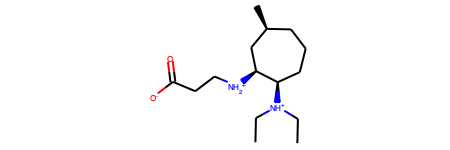

In [216]:
rdkit.Chem.MolFromSmiles('CC[NH+](CC)[C@@H]1CCC[C@H](C)C[C@@H]1[NH2+]CCC(=O)[O-]')

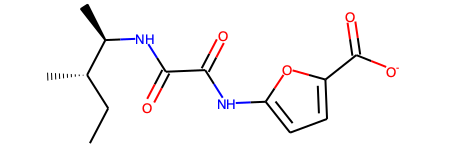

In [217]:
rdkit.Chem.MolFromSmiles('CC[C@H](C)[C@@H](C)NC(=O)C(=O)Nc1ccc(C(=O)[O-])o1')

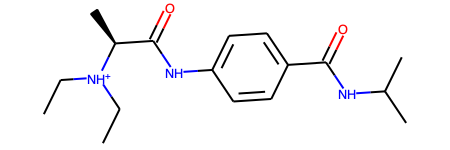

In [218]:
rdkit.Chem.MolFromSmiles('CC[NH+](CC)[C@@H](C)C(=O)Nc1ccc(C(=O)NC(C)C)cc1')

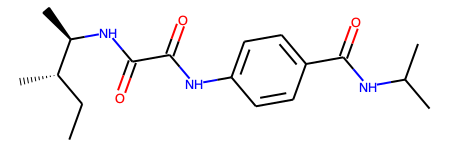

In [219]:
rdkit.Chem.MolFromSmiles('CC[C@H](C)[C@@H](C)NC(=O)C(=O)Nc1ccc(C(=O)NC(C)C)cc1')

## Drugs' distance to Ibuprofen in the latent space

* find the means of latent variables for SMILES of real drugs
* Ibuprofen is not in the 4K training data

In [285]:
data_dir = "/Users/keyu/PycharmProjects/DrugEmbedding/data/"
vocab_file = "zinc_char_list.json"
model_file = 'logistic_KL_annealing_mdl'
w2i, i2w = idx2word(data_dir, vocab_file)
eos_idx = w2i['<eos>']
model = torch.load(model_file)

In [286]:
target_drug = 'Ibuprofen'

In [287]:
#create two dims lists: 1st dim SMILES, 2nd dim chars in SMILES
data_dir = './data/'
train_file = 'all_drugs.smi'
dataset_raw_file = os.path.join(data_dir, train_file)
drugs_dict = {}
with open(dataset_raw_file, 'r') as file:
    for seq in file.readlines():
        if seq != '\n':
            line = seq.split(" ")
            drugs_dict[line[1]] = line[0]
file.close()

In [296]:
drugs_mu_dict = {}
for key in drugs_dict.keys():
    smile_1st = drugs_dict[key]
    input_sequence = [w2i['<sos>']]
    for i in smile_1st:
        try:
            input_sequence.append(w2i[i])
        except:
            input_sequence.append(w2i['<unk>'])
    input_sequence.append(w2i['<eos>'])
    input_sequence = input_sequence + [0] * (max_sequence_length - len(input_sequence)-1)
    input_sequence = np.asarray(input_sequence)
    input_sequence = torch.from_numpy(input_sequence).unsqueeze(0)
    sequence_length = torch.tensor([len(smile_1st)+1])
    _, mean, logv, _= model.forward(input_sequence,sequence_length)
    
    samples_idx,_ = model.inference(1,mean.unsqueeze(0))
    for i in range(1):
        smiles = []
        for j in range(max_sequence_length):
            if samples_idx[i,j] == eos_idx:
                break
            smiles.append(i2w[samples_idx[i,j].item()])
        smiles = "".join(smiles)
    
    drugs_mu_dict[key] = [mean, smiles]

In [297]:
drugs_dist_dict = {}
for key in drugs_mu_dict.keys():
    eu_dist = (drugs_mu_dict[key][0] - drugs_mu_dict[target_drug][0]).pow(2).sum().pow(0.5)
    drugs_dist_dict[key] = eu_dist

In [298]:
df_lst = []
for key in drugs_dict.keys():
    df_lst.append([key, drugs_dict[key], drugs_mu_dict[key][-1],drugs_dist_dict[key].item()])
df = pd.DataFrame(df_lst, columns = ['drug','SMILES','SMILES_VAE','dist'])

In [301]:
#1365 drugs, only 270 unique SMILES_VAE
len(df['SMILES_VAE'].unique())

270

In [300]:
idx = df['SMILES_VAE'] != '[CC(C)(C)OC(=O)NC[C@H]1CCC[C@H](C)C1]'
df[idx].sort_values(by=['dist'])

,drug,SMILES,SMILES_VAE,dist
640,Ibuprofen,CC(C)Cc1ccc(C(C)C(=O)O)cc1,CC(C)(C)OC(=O)NC[C@H]1CCC[C@H](C)C1,0.000000
137,Bepridil,CC(C)COCC(CN(Cc1ccccc1)c1ccccc1)N1CCCC1,CC(C)(C)OC(=O)NC[C@H]1CCC[C@H](C)C1,0.216525
1031,Pindolol,CC(C)NCC(O)COc1cccc2[nH]ccc12,CC(C)(C)OC(=O)NC[C@H]1CCC[C@H](C)C1,0.241444
103,Atenolol,CC(C)NCC(O)COc1ccc(CC(N)=O)cc1,CC(C)(C)OC(=O)NC[C@H]1CCC[C@H](C)C1,0.242473
141,Betaxolol,CC(C)NCC(O)COc1ccc(CCOCC2CC2)cc1,CC(C)(C)OC(=O)NC[C@H]1CCC[C@H](C)C1,0.247049
154,Bisoprolol,CC(C)NCC(O)COc1ccc(COCCOC(C)C)cc1,CC(C)(C)OC(=O)NC[C@H]1CCC[C@H](C)C1,0.263796
1179,Sotalol,CC(C)NCC(O)c1ccc(NS(C)(=O)=O)cc1,CC(C)(C)OC(=O)NC[C@H]1CCC[C@H](C)C1,0.283380
558,Fospropofol,CC(C)c1cccc(C(C)C)c1OCOP(=O)(O)O,CC(C)(C)OC(=O)N1CCC[C@@H](C(=O)Nc2cccc(Cl)c2)C1,0.301341
793,Menthol,CC(C)[C@@H]1CC[C@@H](C)C[C@H]1O,CC(C)(C)OC(=O)NC[C@H]1CCC[C@H](C)C1,0.320884
1151,Salbutamol,CC(C)(C)NCC(O)c1ccc(O)c(CO)c1,CC(C)(C)OC(=O)NC[C@H]1CCC[C@H](C)C1,0.326287


<font color='red'><font size = '3'> COMMENTS </font>
* mean of Ibuprofen falls into a dead spot in latent space (Z), where no information was encoded into
* drugs at bottom seem to have more meaningful representation in Z